In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [6]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [7]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [8]:
dxx=0.5

In [11]:

chunks_new={'time_counter':10}

M='01';mon_x=0

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_dataset(listm[1:][mon_x],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_dataset(listt[1:][mon_x],chunks=chunks_new)



# path='/data/pacific/lrenault/SASI/CROCO/FULL/'
# listm=glob(path+'surf*.nc');listm.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varf=xr.open_mfdataset(listm[1:],data_vars='minimal',chunks=chunks_new)

# path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
# listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
# listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
# #vart=xr.open_dataset(listt[xmon])
# vart=xr.open_mfdataset(listt[1:],data_vars='minimal',chunks=chunks_new)

In [14]:
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'wrf_*.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[::2][-7:][mon_x],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'wrf_*.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[::2][-7:][mon_x],chunks=chunks_new)


# path='/data/pacific/lrenault/SASI/FULL/WRF/'
# listmw=glob(path+'wrf_*.nc');listmw.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varfw=xr.open_mfdataset(listmw[::2][-7:],chunks=chunks_new)

# path='/data/pacific/lrenault/SASI/SMTH/WRF/'
# listtw=glob(path+'wrf_*.nc');listtw.sort()
# #vart=xr.open_dataset(listt[xmon])
# vartw=xr.open_mfdataset(listtw[::2][-7:],chunks=chunks_new)

# Loading data

In [15]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [17]:
%%time
tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:750].compute();
tf=tf[:-1,1:-1,1:-1]

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:750].compute();
tt=tt[:-1,1:-1,1:-1]

shf=varf.shflx#.groupby("time_counter.dayofyear").mean()
shf=shf.chunk(chunks=chunks_new);
shf=shf[:,120:-120,120:750].compute();
shf=shf[:-1,1:-1,1:-1]

sht=vart.shflx#.groupby("time_counter.dayofyear").mean()
sht=sht.chunk(chunks=chunks_new);
sht=sht[:,120:-120,120:750].compute();
sht=sht[:-1,1:-1,1:-1]


sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:750].compute();
sf=sf[:-1,1:-1,1:-1]

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:750].compute();
st=st[:-1,1:-1,1:-1]

rhof=varf.rho#.groupby("time_counter.dayofyear").mean()
rhof=rhof.chunk(chunks=chunks_new);
rhof=rhof[:,120:-120,120:750].compute();
rhof=rhof[:-1,1:-1,1:-1] +varf.rho0

rhot=vart.rho#.groupby("time_counter.dayofyear").mean()
rhot=rhot.chunk(chunks=chunks_new);
rhot=rhot[:,120:-120,120:750].compute();
rhot=rhot[:-1,1:-1,1:-1] +vart.rho0


CPU times: user 2.98 s, sys: 5.04 s, total: 8.02 s
Wall time: 52.6 s


# Computing $Bo_t$

In [18]:
cp=gsw.cp_t_exact(sf,tf,p=0).mean()
rho=1024
g=9.8

In [19]:
ct_f=gsw.CT_from_t(sf,tf,p=0)
alpha_f=gsw.alpha(sf,ct_f,p=0)
# lv_f=gsw.latentheat_evap_CT(sf,ct_f)


ct_t=gsw.CT_from_t(st,tt,p=0)
alpha_t=gsw.alpha(st,ct_t,p=0)
# lv_t=gsw.latentheat_evap_CT(st,ct_t)

In [132]:
# Bot_f=-(alpha_f*g*shf)/(rho*cp)
# Bot_t=-(alpha_t*g*sht)/(rho*cp)
# Bot_f=(alpha_f*g*shf)/(rho*cp) #following Bishop 2020
# Bot_t=(alpha_t*g*sht)/(rho*cp)

Bot_f=(alpha_f.mean()*g*shf)/(rho*cp) #following Bishop 2020
Bot_t=(alpha_t.mean()*g*sht)/(rho*cp)

# Computing $Bo_s$ and $b_S$

##### Loading data from WRF

In [21]:
varfw.coords['2htime']=varfw.time_counter.dt.floor('2H')
vartw.coords['2htime']=vartw.time_counter.dt.floor('2H')

In [22]:
%%time
# chunks_new={'time_counter':40}
lhtf=regrid(varfw.LH.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:750][:,1:-1,1:-1]
lhtt=regrid(vartw.LH.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:750][:,1:-1,1:-1]
Pf=regrid(varfw.RAIN.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:750][:,1:-1,1:-1]
Pt=regrid(vartw.RAIN.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:750][:,1:-1,1:-1]

Create weight file: bilinear_390x300_1520x1000.nc
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 36s, sys: 3.92 s, total: 1min 40s
Wall time: 2min 4s


In [29]:
Pf

<xarray.DataArray 'RAIN' (2htime: 123, y: 1278, x: 628)>
dask.array<getitem, shape=(123, 1278, 628), dtype=float64, chunksize=(1, 1278, 628), chunktype=numpy.ndarray>
Coordinates:
  * 2htime   (2htime) datetime64[ns] 2012-01-01T06:00:00 ... 2012-01-31T18:00:00
    lon      (y, x) float32 -124.4 -124.4 -124.4 -124.4 ... -124.9 -124.9 -124.9
    lat      (y, x) float32 33.28 33.28 33.29 33.29 ... 39.69 39.69 39.69 39.69
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [32]:
# lhtf=lhtf[3:][::3]
# lhtt=lhtt[3:][::3]

# Pf=Pf[3:][::3]
# Pt=Pt[3:][::3]

In [34]:
# L=gsw.latentheat_evap_CT(sf,ct_f).mean().data #J   #/1000 #kJ
L=2257*1000 # J/Kg

In [35]:
Evap_f=lhtf.compute()/(L*rho)# m/s   #*86400
Evap_t=lhtt.compute()/(L*rho)# m/s   #*86400 #mm/day

beta_f=gsw.beta(sf,ct_f,p=0)
beta_t=gsw.beta(st,ct_t,p=0)

In [36]:

EP_f=Evap_f-(Pf.compute()/(12*1000));


EP_t=Evap_t-(Pt.compute()/(12*1000));


In [133]:
# Bos_f=-(g*beta_f)*(sf)*(EP_f.data) # Following Bishop et al (2020)
# Bos_t=-(g*beta_t)*(st)*(EP_t.data)

Bos_f=-(g*beta_f.mean())*(sf)*(EP_f.data) # Following Bishop et al (2020)
Bos_t=-(g*beta_t.mean())*(st)*(EP_t.data)
# Bos_f=-(g*beta_f)*(sf)*(EP_f) 
# Bos_t=-(g*beta_t)*(st)*(EP_t)

# Loading z*

In [86]:
z_star_full=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_full_M01.nc')[:-1,:,1:-1,1:-1]
z_star_smth=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_smth_M01.nc')[:-1,:,1:-1,1:-1]

# Spectral APE flux

In [87]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [142]:
%%time
z_star_Bo_full=xrft.isotropic_cross_spectrum(xr.DataArray(-2 - z_star_full[:,0,:,:].data),
                xr.DataArray((-Bot_f+Bos_f).data),dim=['dim_1','dim_2'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real
z_star_Bo_smth=xrft.isotropic_cross_spectrum(xr.DataArray(-2 - z_star_smth[:,0,:,:].data),
                xr.DataArray((-Bot_t+Bos_t).data),dim=['dim_1','dim_2'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor).real

CPU times: user 5min 19s, sys: 21min 10s, total: 26min 29s
Wall time: 43 s


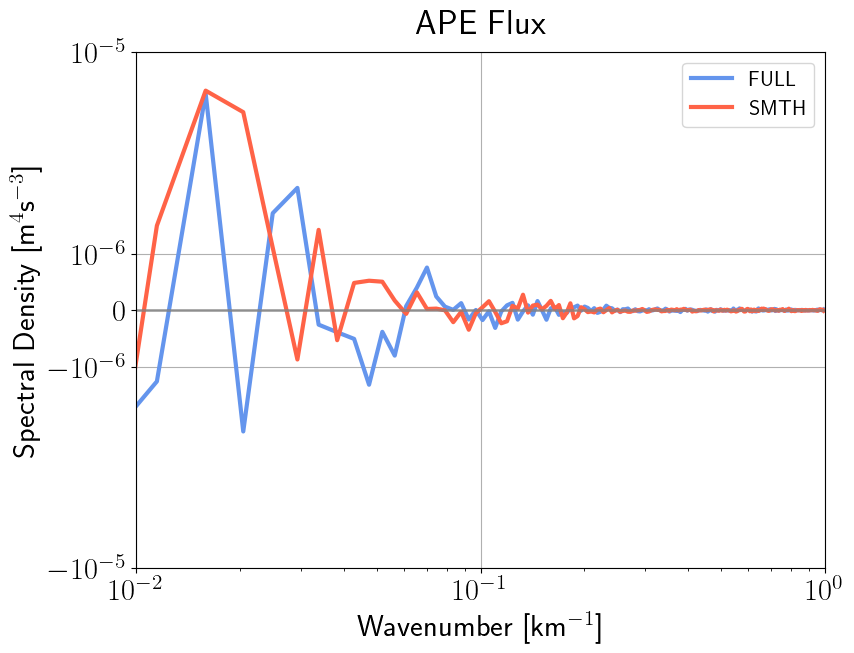

In [156]:
plt.figure(figsize=(9,7))

plt.plot(z_star_Bo_full.freq_r/dxx,
         z_star_Bo_full.mean(axis=0)/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(z_star_Bo_smth.freq_r/dxx,
         z_star_Bo_smth.mean(axis=0)/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')
plt.plot(z_star_Bo_full.freq_r/dxx,np.zeros(z_star_Bo_full[0].shape),linewidth=2,color='grey',alpha=0.7)


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=10**(-5.5))
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'APE Flux',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
# plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
# plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
plt.ylim(-1e-5,1e-5)
plt.grid()

plt.tight_layout()

In [115]:
%%time
z_star_full_spec=xrft.isotropic_power_spectrum(z_star_full[:,:11,:,:],
                dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor)
            
            
z_star_smth_spec=xrft.isotropic_power_spectrum(z_star_smth[:,:11,:,:],
                dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor)

CPU times: user 29min 11s, sys: 1h 53min 58s, total: 2h 23min 10s
Wall time: 5min 30s


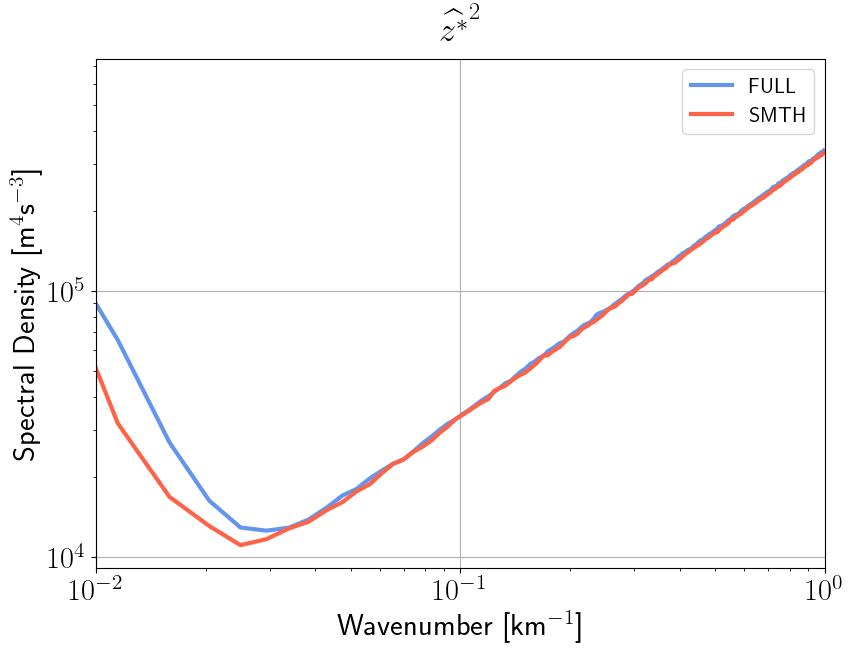

In [131]:
plt.figure(figsize=(9,7))


plt.plot(z_star_full_spec.freq_r/dxx,
         z_star_full_spec[:,0].mean(['ocean_time'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(z_star_smth_spec.freq_r/dxx,
         z_star_smth_spec[:,0].mean(['ocean_time'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')

# plt.plot(z_star_full_spec.freq_r/dxx,
#          z_star_full_spec.mean(['z_rho','ocean_time'])/dxx*1e3,
#          label='FULL',linewidth=3,color='cornflowerblue')

# plt.plot(z_star_smth_spec.freq_r/dxx,
#          z_star_smth_spec.mean(['z_rho','ocean_time'])/dxx*1e3,
#          label='SMTH',linewidth=3,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('log')
# plt.yscale('log')
plt.xscale('log')

plt.title(r'$\widehat{z^*}^2$',fontsize=25,y=1.02)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(-1e-5,1e-)5
plt.grid()

plt.tight_layout()

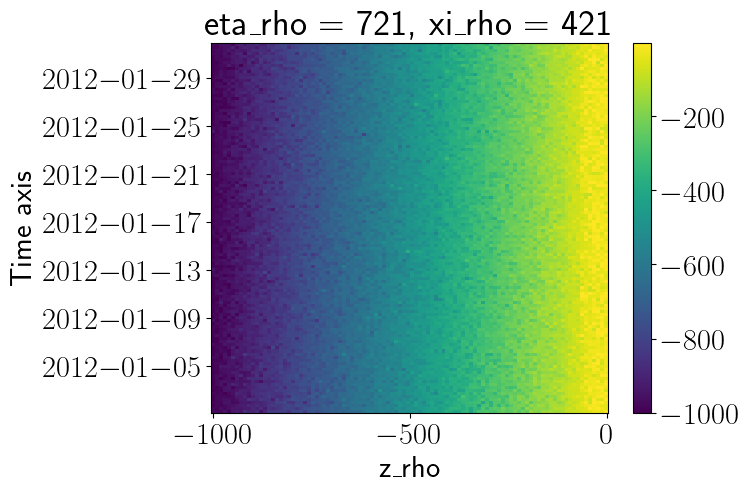

In [159]:
z_star_full[:,:,600,300].plot()